# Assignment 2: The Secrets of Optical Flow

Name: Tushar Choudhary  
Roll number: 2019111019

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import os

# import imageio
from scipy import ndimage

%matplotlib tk
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

https://medium.com/pixel-wise/detect-those-corners-aba0f034078b  
visualize the feature set of pixels obtained by both algorithms that will be tracked by the sparse LK method. 

In [3]:
#Define RGB2gray function
def rgb2gray(img) :
    return np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])

#Detemine gradient function for Fx and Fy using sobel filter(normlized)
def gradient_x(img) :
    grad_img = ndimage.convolve(img, np.array([[-1, 0, 1]]))
    return grad_img/np.max(grad_img)

def gradient_y(img) :
    grad_img = ndimage.convolve(img, np.array([[-1],[0],[1]]))
    return grad_img/np.max(grad_img)

**Harris Corner Detector**

In [8]:
def harris_corner(img_pth, k = 0.05, threshold_ratio = 0.05, dis = 10):
    
    input_img = cv2.imread(img_pth)
    gray_input_img = rgb2gray(input_img) 
    # Not using cv2.cvtColor to avoid integral values

    Ix = gradient_x(gray_input_img)
    Iy = gradient_y(gray_input_img)
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    window_results = [] 
    thresh_pts = []
    final_thresh_pts = [] 
    x_hcd = [] 
    y_hcd = []
    mx_res = 0

    for i in range(4, int(input_img.shape[0] - 4)):
            for j in range(4, int(input_img.shape[1] - 4)):
                H = [[0, 0], [0, 0]]
                # Taking window of size 9x9 and calculating Harris response value
                H[0][0] = np.sum(Ixx[i-4 : i+5 , j-4 : j+5])
                H[1][1] = np.sum(Iyy[i-4 : i+5 , j-4 : j+5])
                H[0][1] = np.sum(Ixy[i-4 : i+5 , j-4 : j+5])
                H[1][0] = np.sum(Ixy[i-4 : i+5 , j-4 : j+5])
                determinant = H[0][0] * H[1][1] - H[0][1] * H[1][0]
                trace = H[0][0] + H[1][1]
                res = determinant - k * trace * trace
                window_results.append((i, j, res))
                if(res > mx_res) :
                    mx_res = res

    # Choosing points of interest
    for window_res in window_results :
        i, j, res = window_res
        if res > threshold_ratio * mx_res :
            thresh_pts.append([i, j, res])
    
    print(f"Initially found {len(thresh_pts)} points of interest.")

    # Performing non-maximal supression
    sorted_thresh_pts = sorted(thresh_pts, key = lambda x: x[2], reverse = True)
    final_thresh_pts.append(sorted_thresh_pts[0][:-1])
    for i in sorted_thresh_pts :
        for j in final_thresh_pts :
            if(abs(i[0] - j[0] <= dis) and abs(i[1] - j[1]) <= dis) :
                break
        else :
            final_thresh_pts.append(i[:-1])
            x_hcd.append(i[1])
            y_hcd.append(i[0])

    print(f"After non-maximal supressions {len(final_thresh_pts)} points were left")

    #Print Final Image
    corner_img = np.zeros(input_img.shape)

    for i in final_thresh_pts :
        y, x = i[0], i[1]
        corner_img[y][x] = 1

    plt.imshow(input_img)
    plt.plot(x_hcd, y_hcd, '*', color='red')
    plt.savefig("../results/harris_corner_result.jpg")
    print("Image saved at ../results/harris_corner_result.jpg")
    plt.show()

Initially found 25063 points of interest.
After non-maximal supressions 126 points were left
Image saved at ../results/harris_corner_result.jpg


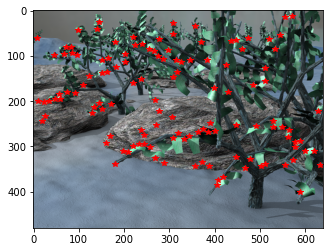

In [9]:
harris_corner('../data/all-frames-colour/Grove3/frame07.png')